<a href="https://colab.research.google.com/github/carlosmvond/modelos_predictivos/blob/main/MP_Clase4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


En este código vamos a calibrar una regresión lineal usando inferencia bayesiana.

El primer código genera datos sintéticos a paratir de una ecuación de recta y errores aleatorios. La recta es $y=\alpha_{original} x +\beta_{original}$, y los errores se generan usando la distribución normal $N(0, \sigma)$.


En el segundo código definimos el siguiente modelo bayesiano usando la sintaxis de la librería PyMC:

$$y_i^{obs} \sim N(\alpha x_i+\beta_i+\epsilon_i, \sigma).$$


Finalmente en el tercer código se hacen gráficos del modelo ajustado (media y HDI).

* Antes de lanzar los códigos, quizás deba instalar las librerías
* ¿Que distribuciones a priori se utilizaron al definir el modelo bayesiano?
* Ejecute el código agregando un error más grande a los datos sintéticos, esto es, modificando $\sigma_{original}$.



**NO OLVIDEN INSTALAR PyMC!!**



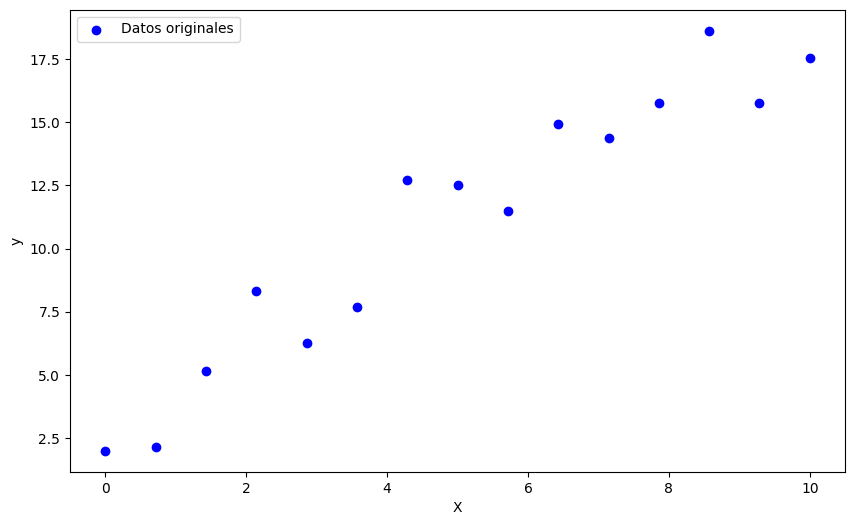

In [20]:

#GENERACIÓN DE DATOS SINTÉTICOS

#!pip install pymc     # Para instalar PyMC!


import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# 1. Generar datos a partir de una regresión lineal y agregar error
np.random.seed(42)
X = np.linspace(0, 10, 15)
alpha_original = 1.0  # Intercepto
beta_original = 2.0   # Pendiente
sigma_original = 2.0  # Desviación estándar del error

# Generar la relación lineal
y = alpha_original + beta_original * X + np.random.normal(0, sigma_original, size=X.shape)

# Crear un gráfico de dispersión
plt.figure(figsize=(10, 6))

# Graficar los puntos originales sin los outliers
plt.scatter(X, y, color='blue', label='Datos originales')

# Añadir etiquetas y título
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

# Mostrar el gráfico
plt.show()



Ahora ajustamos una regresión lineal utilizando PyMC.

In [22]:
#MODELO BAYESIANO


# 2. Ajustar una regresión lineal usando PyMC
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)

    mu = alpha + beta * X
    # Usar la distribución Student's t para las observaciones
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    trace = pm.sample(500, tune=500, return_inferencedata=True)



<ipython-input-23-704269d616fa>:20: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_pred_hdi = az.hdi(y_pred_samples, hdi_prob=0.95)  # Intervalos creíbles del 95%


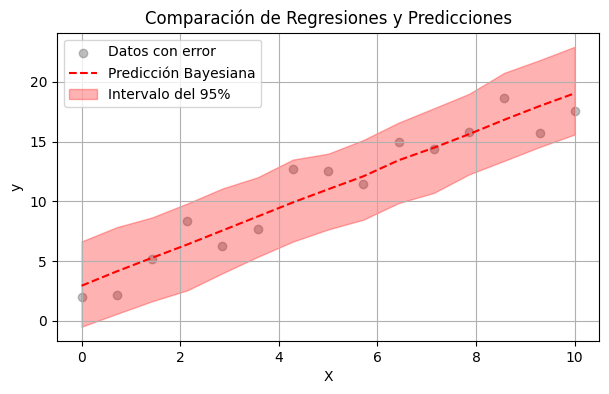

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha  2.927  0.801     1.458      4.531      0.038    0.028     462.0   
beta   1.623  0.134     1.376      1.904      0.006    0.004     474.0   
sigma  1.634  0.303     1.104      2.227      0.014    0.010     472.0   

       ess_tail  r_hat  
alpha     451.0    1.0  
beta      404.0    1.0  
sigma     360.0    1.0  


In [23]:


#GRÁFICOS

# 3. Crear gráficos

# HDI (Intervalo de Densidad Alta) para la regresión bayesiana
alpha_samples = trace.posterior['alpha'].values.flatten()
beta_samples = trace.posterior['beta'].values.flatten()
sigma_samples = trace.posterior['sigma'].values.flatten()

y_pred_samples = np.empty((len(alpha_samples), len(X)))

for i in range(len(alpha_samples)):
    # Calcular el parámetro de ubicación (mu) para la muestra actual
    mu = alpha_samples[i] + beta_samples[i] * X
    # Generar predicciones usando la distribución normal
    y_pred_samples[i] = np.random.normal(loc=mu, scale=sigma_samples[i], size=len(X))

# 4. Calcular la media y los intervalos creíbles para las predicciones
y_pred_mean = y_pred_samples.mean(axis=0)  # Media de las muestras predichas
y_pred_hdi = az.hdi(y_pred_samples, hdi_prob=0.95)  # Intervalos creíbles del 95%

# Graficar los resultados
plt.figure(figsize=(7, 4))

# Graficar datos originales con errores
plt.scatter(X, y, label='Datos con error', color='gray', alpha=0.5)

# Línea de regresión bayesiana (predicción media)
plt.plot(X, y_pred_mean, label='Predicción Bayesiana', color='red', linestyle='--')

# Intervalos creíbles para las predicciones bayesianas
plt.fill_between(X, y_pred_hdi[:, 0], y_pred_hdi[:, 1], color='red', alpha=0.3, label='Intervalo del 95%')

# Detalles para el gráfico
plt.xlabel('X')
plt.ylabel('y')
plt.title('Comparación de Regresiones y Predicciones')
plt.legend()
plt.grid()

# Mostrar el gráfico
plt.show()

# 5. Summary of the predictions
summary = az.summary(trace, hdi_prob=0.95)
print(summary)





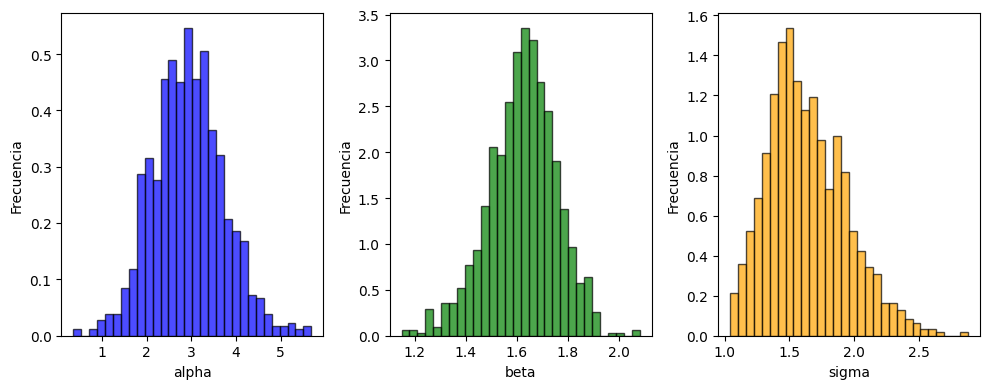

In [24]:
#HISTOGRAMAS

# 6. Crear histogramas para los parámetros
plt.figure(figsize=(10, 4))

# Histograma de alpha
plt.subplot(1, 3, 1)
plt.hist(alpha_samples, bins=30, color='blue', edgecolor='k', alpha=0.7, density=True)
plt.xlabel('alpha')
plt.ylabel('Frecuencia')

# Histograma de beta
plt.subplot(1, 3, 2)
plt.hist(beta_samples, bins=30, color='green', edgecolor='k', alpha=0.7, density=True)
plt.xlabel('beta')
plt.ylabel('Frecuencia')

# Histograma de sigma
plt.subplot(1, 3, 3)
plt.hist(sigma_samples, bins=30, color='orange', edgecolor='k', alpha=0.7, density=True)
plt.xlabel('sigma')
plt.ylabel('Frecuencia')

# Ajustar el diseño de los subgráficos
plt.tight_layout()

# Mostrar los histogramas
plt.show()